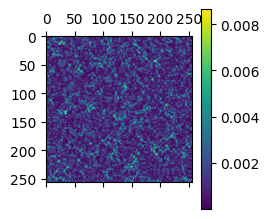

In [43]:
import torch 
import numpy as np
import unfoldNd
import matplotlib.pyplot as plt
%matplotlib inline

torch.set_grad_enabled(False)

d = torch.tensor(np.load("ks2d_short.npy"))
maxval, minval = d.max(), d.min()
normalize = lambda x: (x-minval)/(maxval-minval)
denormalize = lambda x: x*(maxval-minval)+minval
d = normalize(d)

def unfold(d, axis, extent):
    ks = 2*extent + 1

    if axis == 0: d = d.permute(0,2,1)
    b, M0, M1 = d.shape
    
    d = torch.cat((d[:,:,-extent:], d, d[:,:,:extent]), dim=2)
    d = unfoldNd.unfoldNd(d, ks)
    d = d.view(b, M0, ks, M1)
    d = d.permute(0,1,3,2)
    d = d.reshape(-1, ks)
    return d

def fold(d, axis, shape):
    _, channels = d.shape
    if axis == 1: b, M0, M1 = shape
    if axis == 0: b, M1, M0 = shape

    d = d.view(b, M0, M1, channels)

    if axis == 0: d = d.permute(0,2,1,3)
    return d

class SlicedELM2D(torch.nn.Module):
    def __init__(self, extent=2, hidden=100):
        super().__init__()
        self.extent = extent
        self.ks = 2*self.extent + 1
        self.hidden = hidden
        self.phi_sliced = torch.nn.Sequential(torch.nn.Linear(self.ks, self.hidden), torch.nn.Softplus()).double()
        self.out_layer = torch.nn.Linear(self.hidden, 1, bias=False).double()

    def phi(self, X):
        b, N0, N1 = X.shape
        phi_a0 = fold(self.phi_sliced(unfold(X, 0, self.extent)), 0, (b, N0, N1))
        phi_a1 = fold(self.phi_sliced(unfold(X, 1, self.extent)), 1, (b, N0, N1))
        res = phi_a0 + phi_a1
        return res
    
    def forward(self, X):
        unbatched = len(X.shape)==2
        if unbatched: X = X.unsqueeze(0)
        phiX = self.phi(X)
        out = self.out_layer(phiX)
        if unbatched: out = out.squeeze(0)
        return out[...,0]

    def train(self, X, Y):
        phiX = self.phi(X)
        channels = phiX.shape[-1]
        phiX = phiX.reshape(-1, channels)
        Y = Y.view(-1, 1)
        A = torch.linalg.lstsq(phiX, Y).solution.transpose(0,1)
        self.out_layer.weight.data = A

model = SlicedELM2D(3, 50)
noise_distr = torch.distributions.Normal(0, 1e-2)
X = d[0,None,...] 
X = X + noise_distr.sample(X.shape) 
Y = d[5,None,...]

model.train(X, Y)
err = ( model(d[0,...])-d[1,...] ).abs()
plt.colorbar(plt.imshow(err.numpy()))
plt.show()

In [44]:

# enjoy a nice animation
import itertools
%matplotlib qt
# torch.set_grad_enabled(False)
# d = next(iter(Dataset("ks2d_long.npy")))
# T = normalize(d[0,...])[None,...]
T = d[0,None,...]

im = plt.matshow(T[0,...].numpy(), vmin=0, vmax=1)
model_fast= model.to(torch.float32).to("cuda")
T_fast = T.to(torch.float32).to("cuda")
energy = T_fast.mean()
for j in itertools.count():
    T_fast = model_fast(T_fast)
    T_fast = energy + T_fast - T_fast.mean()
    if j % 10 == 0:
        im.set_data(T_fast[0,...].cpu())
        plt.pause(0.000001)
        plt.draw()

KeyboardInterrupt: 